In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from installdatabase import *

path = r'C:\Users\zhaoz\Desktop\finalproject_3035875428_3035876678\data'

In [6]:
clickhouse_query('''
select count(*) as no_of_obs,
    min(year) as min_year,
    max(year) as max_year,
    count(distinct cik_expanded) as no_funds,
    count(distinct adsh) as no_of_files
    from common_goods.last_entry
    where esg_labels is not null 
    and year != 0
    /*i have checked the and found that there are 2 abnormal observations not meaningful*/
''')

Elapsed time: 0 days 00:00:00 seconds


,no_of_obs,min_year,max_year,no_funds,no_of_files
0,1593,2015,2022,1429,1593


In [7]:
clickhouse_query('select distinct year from common_goods.last_entry order by year')

Elapsed time: 0 days 00:00:00 seconds


,year
0,0
1,2015
2,2016
3,2017
4,2018
5,2019
6,2020
7,2021
8,2022


In [8]:
clickhouse_query('select distinct esg_labels from common_goods.last_entry')

Elapsed time: 0 days 00:00:00 seconds


,esg_labels
0,Non-ESG
1,Corporate Governance
2,Community Relations
3,Natural Capital
4,Climate Change
5,Human Capital


# <font color = 'green'> 1. Trend of ESG-Labels by year.</font>

In [7]:
#percentage of esg strategies total
clickhouse_query('''
select count(case when esg_labels != 'Non-ESG' then 1 end) as no_of_esg_strategies, 
count(case when esg_labels != 'Non-ESG' then 1 end) / count(*) * 100 as pct_of_esg_strategies
from common_goods.last_entry
''')

Elapsed time: 0 days 00:00:00 seconds


,no_of_esg_strategies,pct_of_esg_strategies
0,261,16.3125


In [8]:
#percentage of esg strategies in each year
pct_esg_strategies = clickhouse_query('''
select year, count(case when esg_labels != 'Non-ESG' then 1 end) as no_of_esg_strategies,
count(case when esg_labels != 'Non-ESG' then 1 end) / count(*) * 100 as pct_of_esg_strategies
from common_goods.last_entry
where year != 0
group by year
order by year
''')

pct_esg_strategies

Elapsed time: 0 days 00:00:00 seconds


,year,no_of_esg_strategies,pct_of_esg_strategies
0,2015,1,33.333333
1,2016,26,13.829787
2,2017,180,15.845070
3,2018,18,29.508197
4,2019,10,12.820513
5,2020,14,24.137931
6,2021,6,11.764706
7,2022,4,22.222222


## <font color = 'green'> Number of ESG-labeled strategies by year. </font>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


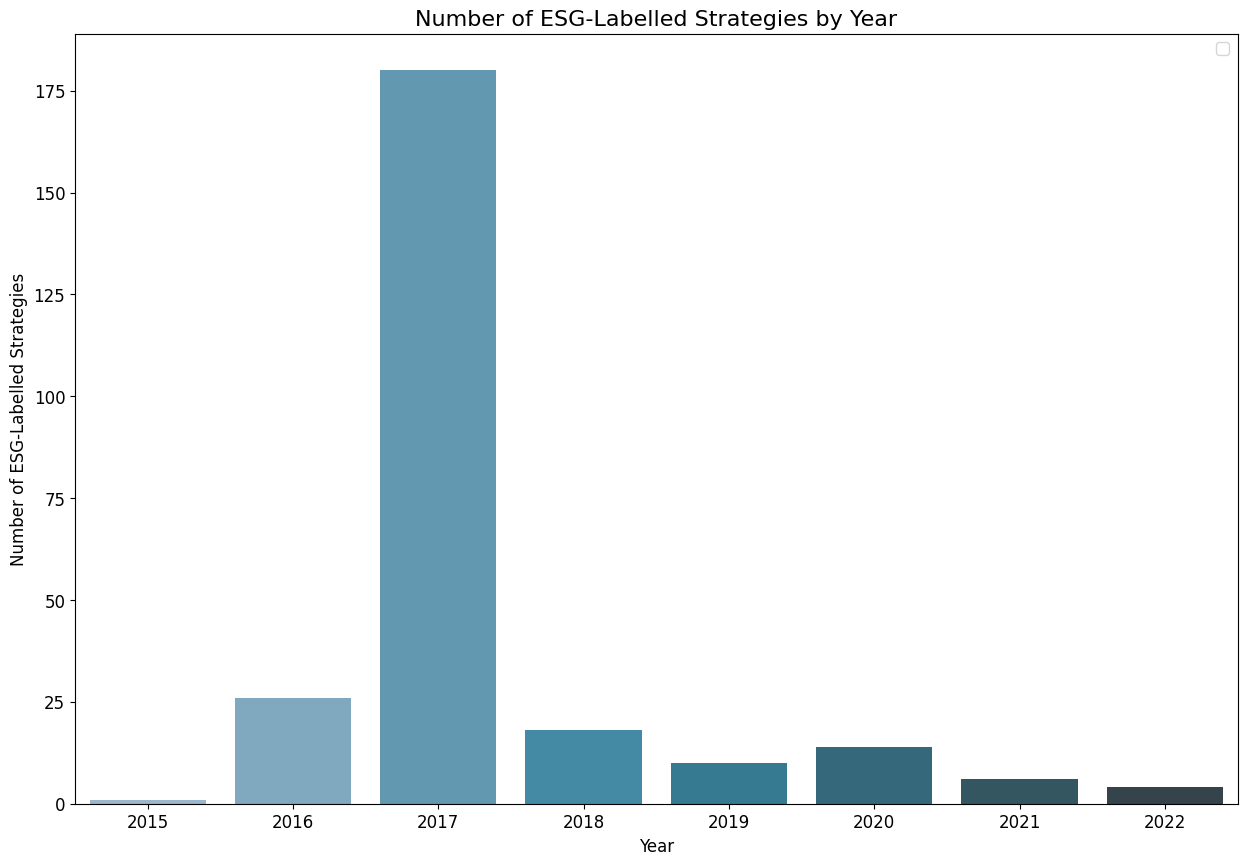

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='year', y='no_of_esg_strategies', data=pct_esg_strategies, palette='PuBuGn_d')
ax.set_title('Number of ESG-Labelled Strategies by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of ESG-Labelled Strategies', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(fontsize=12)

### <font color = 'green'> Why so many ESG-labelled strateiges in 2017? </font>

In [10]:
#esg labels in 2017
esg_labels_2017 = clickhouse_query('''
select esg_labels, 
count(case when strategy != '' then 1 end) as no_of_strategies,
count(case when strategy != '' then 1 end) * 100.0 / sum(count(case when strategy != '' then 1 end)) over () as pct_of_strategies
from common_goods.last_entry
where year = 2017 and esg_labels != 'Non-ESG'
group by esg_labels
order by count(*) desc
''')

esg_labels_2017

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,no_of_strategies,pct_of_strategies
0,Corporate Governance,172,95.555556
1,Community Relations,4,2.222222
2,Climate Change,3,1.666667
3,Human Capital,1,0.555556


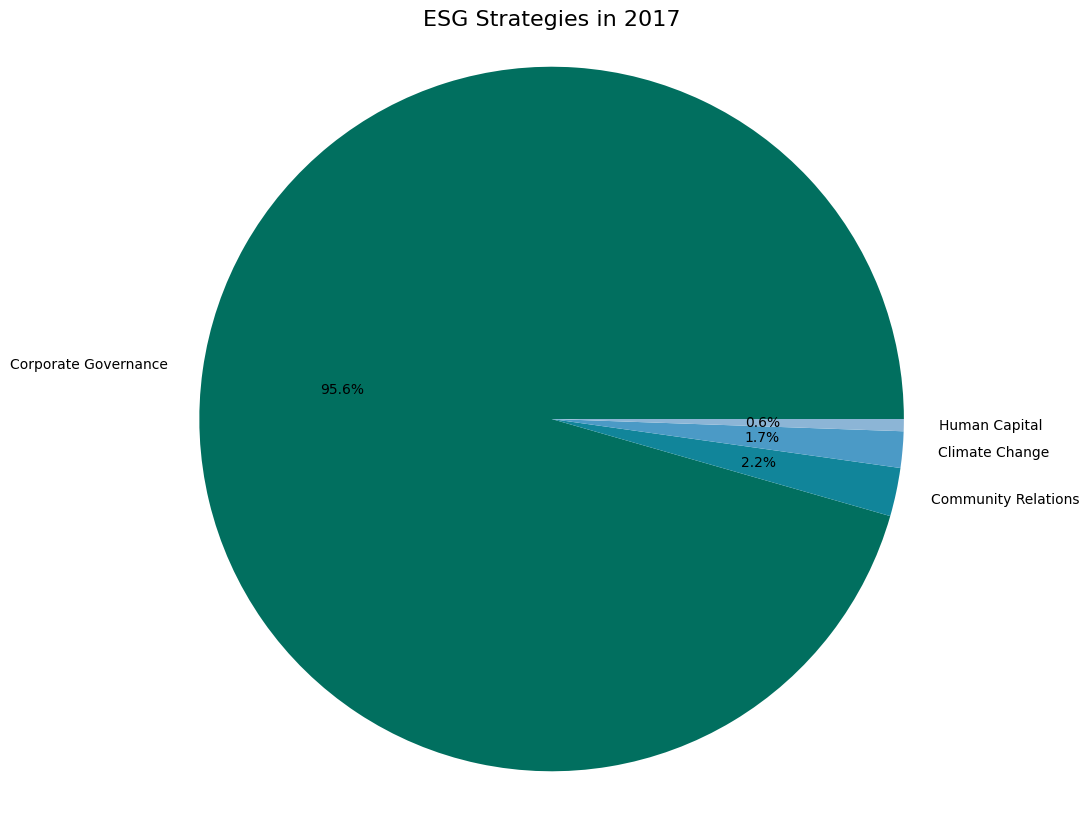

In [11]:
#draw a pie chart to show the distribution of esg labels

labels = esg_labels_2017['esg_labels'].tolist()
sizes = esg_labels_2017['pct_of_strategies'].tolist()

fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette('PuBuGn_r')[0:5]
ax.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0, textprops={'fontsize': 10})
ax.set_title('ESG Strategies in 2017', fontsize=16)
ax.axis('equal')

plt.show()

We found that most of the esg-labeled strategies in 2017 are labeled as *Corporate Governance*. So, we'd like to check the strategies and see if there is any special reason.

In [12]:
#check the strategies labeled as 'Coporate Governance' in 2017
corporate_governance_2017 = clickhouse_query('''
select year, name, adsh, strategy
from common_goods.last_entry
where esg_labels = 'Corporate Governance' and year = 2017
''')

corporate_governance_2017

Elapsed time: 0 days 00:00:00 seconds


,year,name,adsh,strategy
0,2017,DREYFUS FUND INC,0000030146-17-000010,"To pursue its goals, the fund primarily invest..."
1,2017,"DREYFUS RESEARCH GROWTH FUND, INC",0000030162-17-000008,"To pursue its goals, the fund normally invests..."
2,2017,"DREYFUS SUSTAINABLE U.S. EQUITY FUND, INC.",0000030167-17-000036,"To pursue its goal, the fund normally invests ..."
3,2017,DREYFUS FUNDS INC,0000038403-17-000015,"To pursue its goal, the fund normally invests ..."
4,2017,AMCAP FUND,0000051931-17-000146,The fund invests primarily in common stocks of...
...,...,...,...,...
167,2017,FEDERATED MDT SERIES,0001623632-17-000883,The Fund seeks to achieve its objective by inv...
168,2017,GLOBAL X FUNDS,0001628280-17-000766,The Fund invests at least 80% of its total ass...
169,2017,TRANSPARENT VALUE TRUST,0001628280-17-001355,The Fund uses a passive management strategy de...
170,2017,DAVIS FUNDAMENTAL ETF TRUST,0001670310-17-000022,The Fund is an actively managed exchange-trade...


In [14]:
corporate_governance_2017.to_csv(path + os.sep + 'corporate_governance_2017.csv', index=False)

## <font color = 'green'> Composition of ESG-labeled strategies by year. </font>

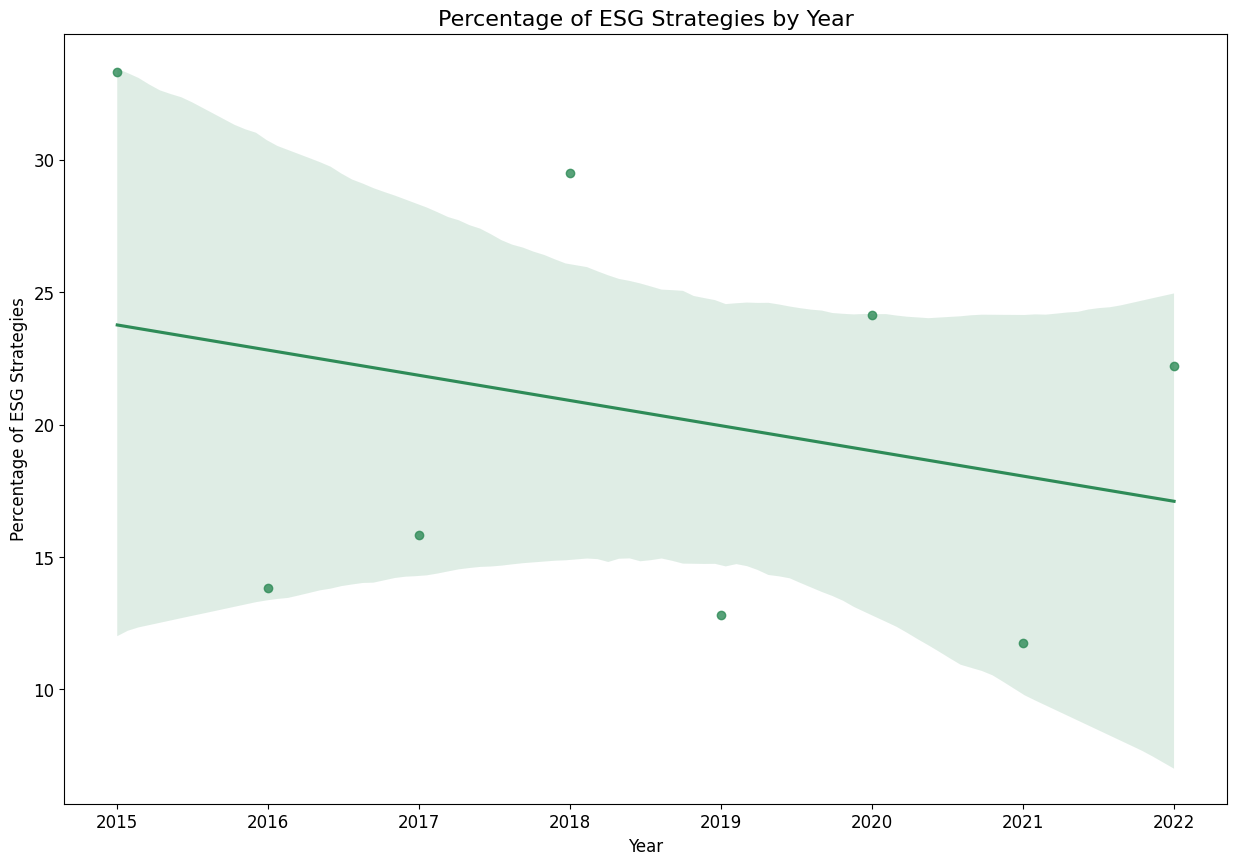

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x = 'year', y = 'pct_of_esg_strategies', data=pct_esg_strategies, color='seagreen', ax=ax)
ax.set_title('Percentage of ESG Strategies by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of ESG Strategies', fontsize=12)
ax.tick_params(labelsize=12)

Surprisingly, we found that percentage of ESG-labelled strategies peaked in 2015. So, we'd like to check the strategies in 2015.

In [16]:
#esg labels in 2015
esg_labels_2015 = clickhouse_query('''
select esg_labels, 
count(case when strategy != '' then 1 end) as no_of_strategies,
count(case when strategy != '' then 1 end) * 100.0 / sum(count(case when strategy != '' then 1 end)) over () as pct_of_strategies
from common_goods.last_entry
where year = 2015
group by esg_labels
order by count(*) desc
''')

esg_labels_2015

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,no_of_strategies,pct_of_strategies
0,Non-ESG,2,66.666667
1,Corporate Governance,1,33.333333


In [17]:
#total number of strategies in each year
clickhouse_query('''
select year, count(*) as no_of_strategies
from common_goods.last_entry
where year != 0
group by year
order by year asc
''')

Elapsed time: 0 days 00:00:00 seconds


,year,no_of_strategies
0,2015,3
1,2016,188
2,2017,1136
3,2018,61
4,2019,78
5,2020,58
6,2021,51
7,2022,18


We can see that this is due to the denominator effect, i.e., there are too few observations in 2015. So, we exclude the year 2015 and check the trend again.

In [4]:
#percentage of esg strategies in each year excluding 2015
pct_esg_strategies_since_2016 = clickhouse_query('''
select year, count(case when esg_labels != 'Non-ESG' then 1 end) / count(*) * 100 as pct_of_esg_strategies
from common_goods.last_entry
where year > 2015
group by year
order by year
''')

pct_esg_strategies_since_2016

Elapsed time: 0 days 00:00:00 seconds


,year,pct_of_esg_strategies
0,2016,13.829787
1,2017,15.845070
2,2018,29.508197
3,2019,12.820513
4,2020,24.137931
5,2021,11.764706
6,2022,22.222222


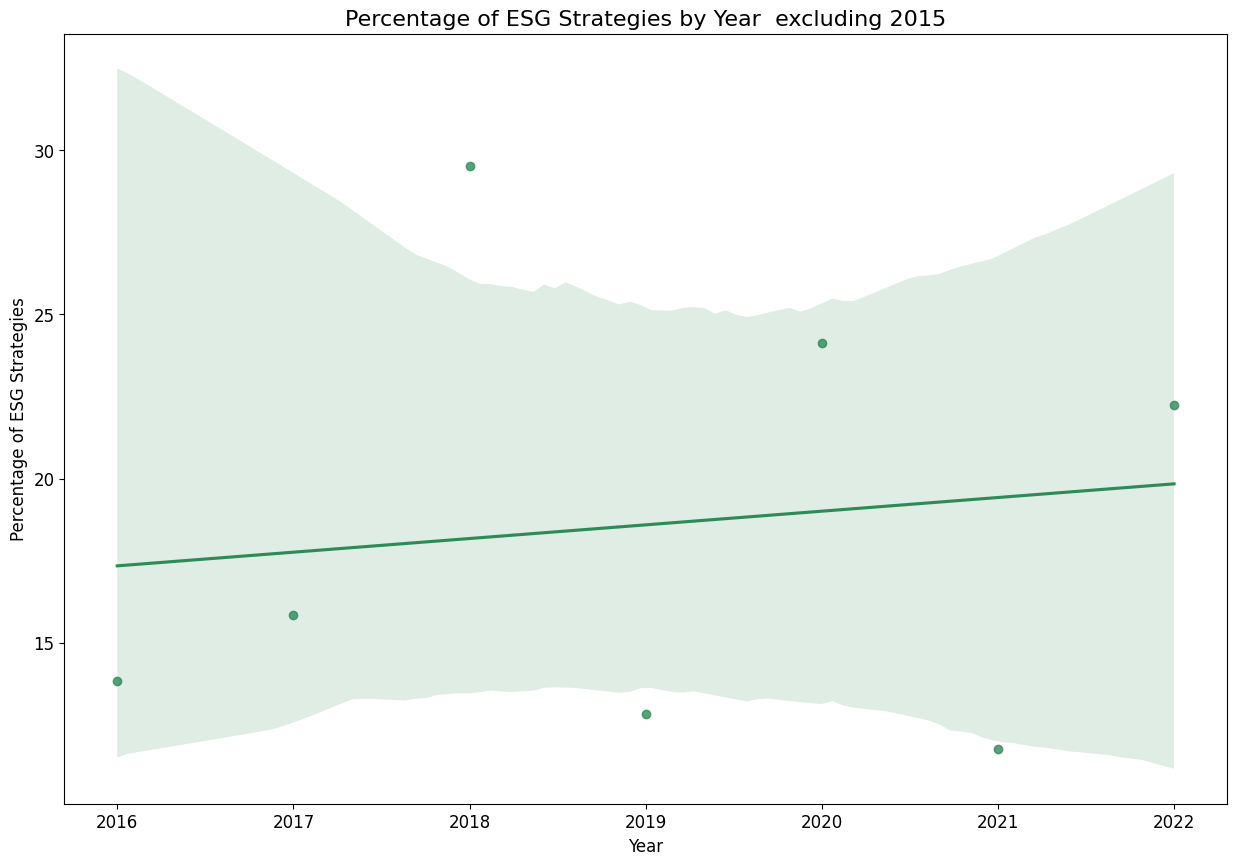

In [5]:
#plot
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x = 'year', y = 'pct_of_esg_strategies', data=pct_esg_strategies_since_2016, color='seagreen', ax=ax)
ax.set_title('Percentage of ESG Strategies by Year  excluding 2015', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of ESG Strategies', fontsize=12)
ax.tick_params(labelsize=12)

Now we can see an upward trend of ESG-labelled strategies.

## <font color = 'green'> ESG Strategies within each ESG label. </font>

In [6]:
#count labels for each year
esg_strategies_yearly = clickhouse_query('''
select year, esg_labels, count(*) as no_of_labels,
count(*)/ sum(count(esg_labels)) over (partition by year) *100 as pct_of_labels
from common_goods.last_entry
where year != 0 and esg_labels != 'Non-ESG'
group by year, esg_labels
order by year, count(*) desc
''')

esg_strategies_yearly

Elapsed time: 0 days 00:00:00 seconds


,year,esg_labels,no_of_labels,pct_of_labels
0,2015,Corporate Governance,1,100.000000
1,2016,Corporate Governance,24,92.307692
2,2016,Community Relations,1,3.846154
3,2016,Natural Capital,1,3.846154
4,2017,Corporate Governance,176,97.777778
5,2017,Climate Change,2,1.111111
6,2017,Community Relations,2,1.111111
7,2018,Corporate Governance,17,94.444444
8,2018,Human Capital,1,5.555556
9,2019,Corporate Governance,10,100.000000


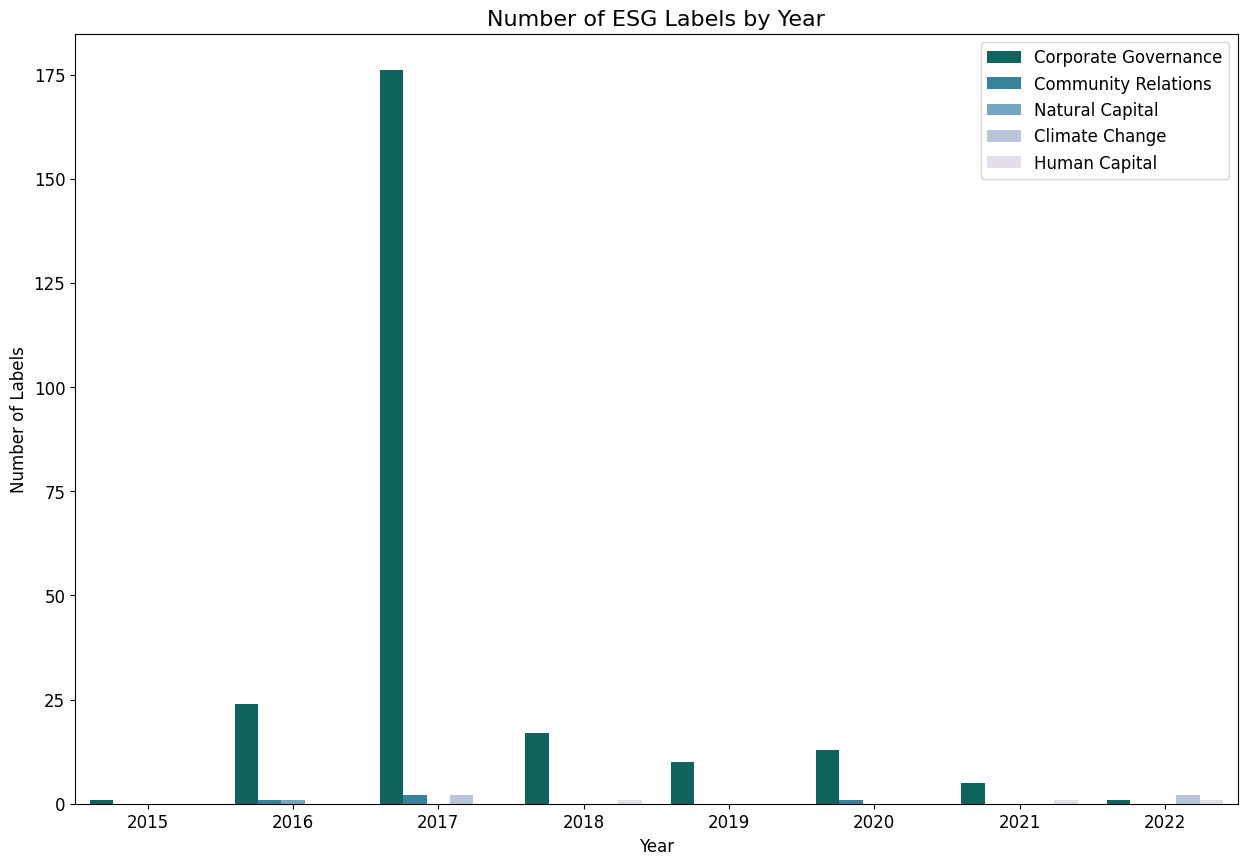

In [7]:
esg_strategies_yearly['year'] = esg_strategies_yearly['year'].astype(str)

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='year', y='no_of_labels', hue='esg_labels', palette='PuBuGn_r', data=esg_strategies_yearly, ax=ax)
ax.set_title('Number of ESG Labels by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Labels', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(fontsize=12)

plt.show()

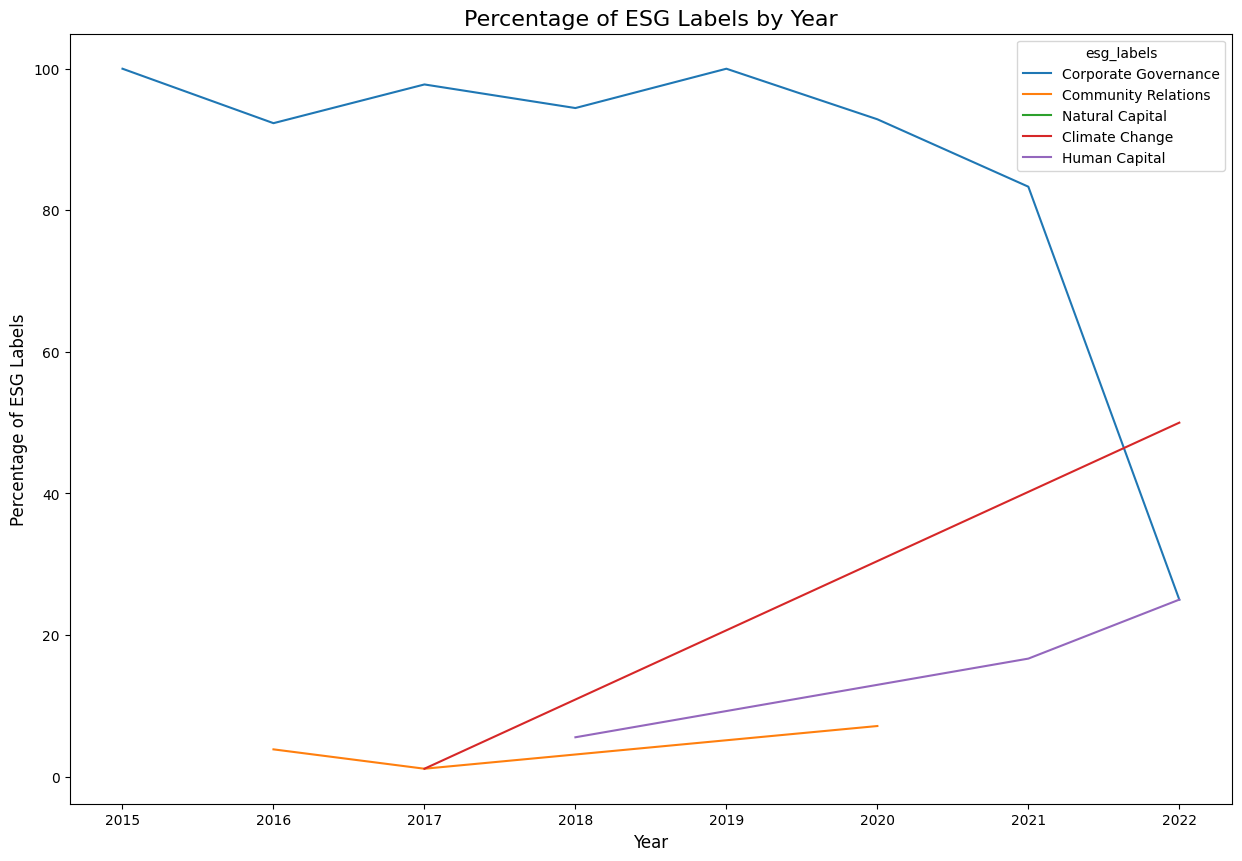

In [22]:
#plot percentage of esg labels by year
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x='year', y='pct_of_labels', hue='esg_labels', data=esg_strategies_yearly, ax=ax)
ax.set_title('Percentage of ESG Labels by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of ESG Labels', fontsize=12)

plt.show()

*Corporate Governance* dominate in every year before 2022. Other labels co-move. </br>

# <font color = 'green'> 2. Trend of ESG-labeled funds by year. </font>

In [9]:
esg_labelled_funds = clickhouse_query('''
select year, no_of_funds,
100 - no_of_funds * 100.0 / total_no_of_funds as pct_of_esg_funds
from (select 
year, esg_labels, count(distinct cik_expanded) as no_of_funds,
sum(count(distinct cik_expanded)) over (partition by year) as total_no_of_funds
from common_goods.last_entry
where year != 0
group by year, esg_labels) 
where esg_labels = 'Non-ESG'
order by year asc
''')

esg_labelled_funds

Elapsed time: 0 days 00:00:00 seconds


,year,no_of_funds,pct_of_esg_funds
0,2015,2,33.333333
1,2016,162,13.829787
2,2017,945,15.925267
3,2018,43,29.508197
4,2019,68,12.820513
5,2020,44,24.137931
6,2021,45,11.764706
7,2022,14,22.222222


## <font color = 'green'> Number of ESG-labeled funds by year. </font>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


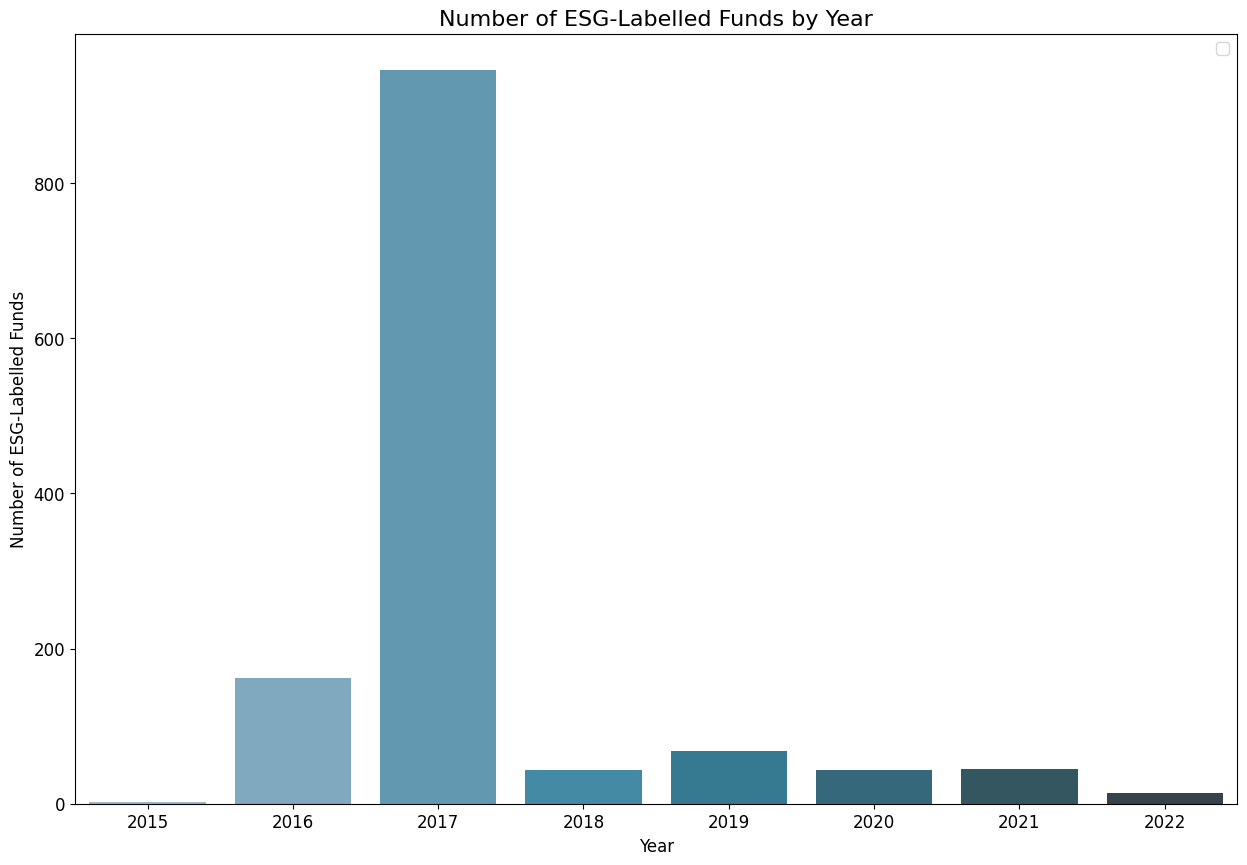

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='year', y='no_of_funds', data=esg_labelled_funds, palette='PuBuGn_d')
ax.set_title('Number of ESG-Labelled Funds by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of ESG-Labelled Funds', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(fontsize=12)

## <font color = 'green'> Percentage of ESG-labeled funds by year. </font>

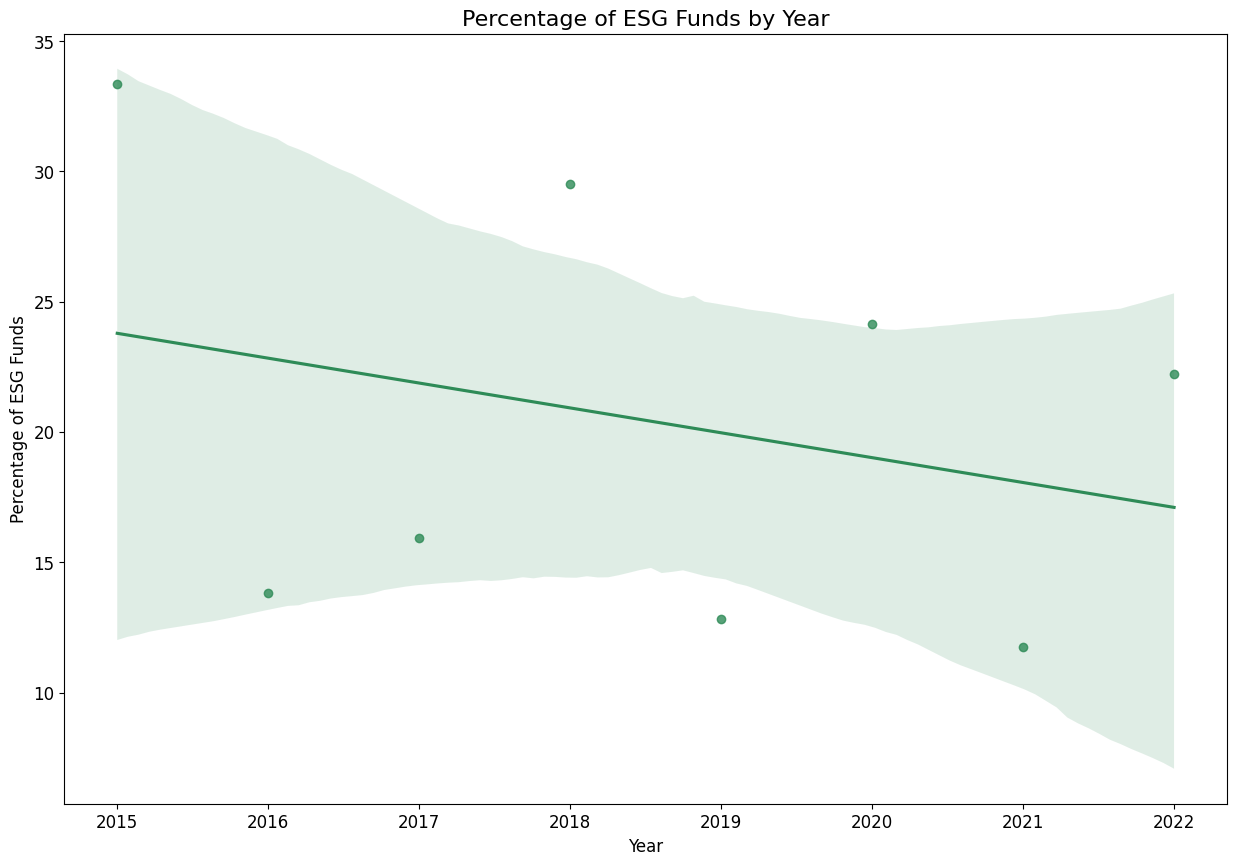

In [11]:
esg_labelled_funds['year'] = esg_labelled_funds['year'].astype(float)

fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='year', y='pct_of_esg_funds', data=esg_labelled_funds, ax=ax, color='seagreen')
ax.set_title('Percentage of ESG Funds by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of ESG Funds', fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

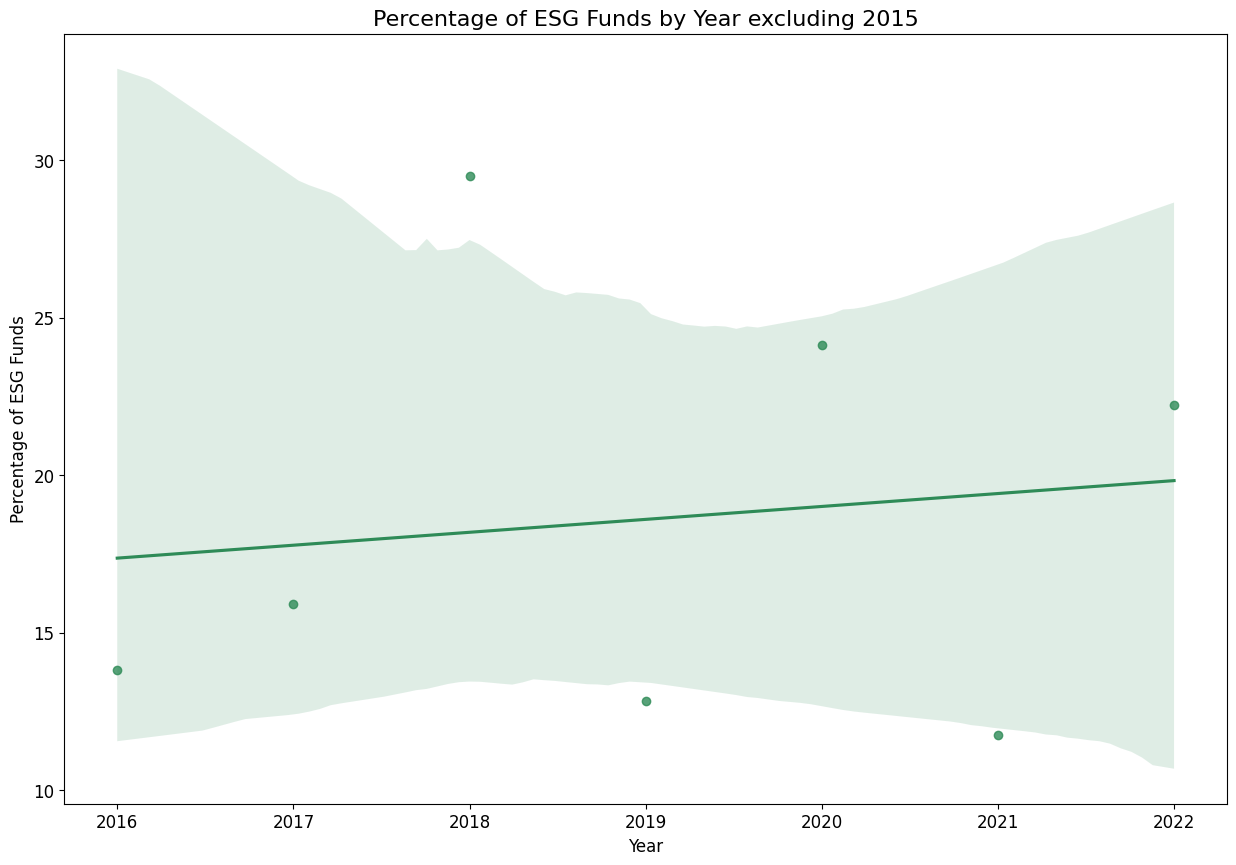

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='year', y='pct_of_esg_funds', data=esg_labelled_funds[1:], ax=ax, color='seagreen')
ax.set_title('Percentage of ESG Funds by Year excluding 2015', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percentage of ESG Funds', fontsize=12)
ax.tick_params(labelsize=12)

plt.show()

Similar to the trend of ESG-labeled strategies, we can see a upward trend of ESG-labelled funds since 2016.

## <font color = 'green'> Funds trading within each ESG label. </font>

In [14]:
esg_funds = clickhouse_query('''
select esg_labels, count(distinct cik_expanded) as no_of_funds,
count(distinct cik_expanded) * 100.0 / sum(count(distinct cik_expanded)) over () as pct_of_funds
from common_goods.last_entry
where esg_labels != 'Non-ESG'
group by esg_labels
order by count(distinct cik_expanded) desc
''')

esg_funds

Elapsed time: 0 days 00:00:00.001012 seconds


,esg_labels,no_of_funds,pct_of_funds
0,Corporate Governance,231,95.061728
1,Climate Change,4,1.646091
2,Community Relations,4,1.646091
3,Human Capital,3,1.234568
4,Natural Capital,1,0.411523


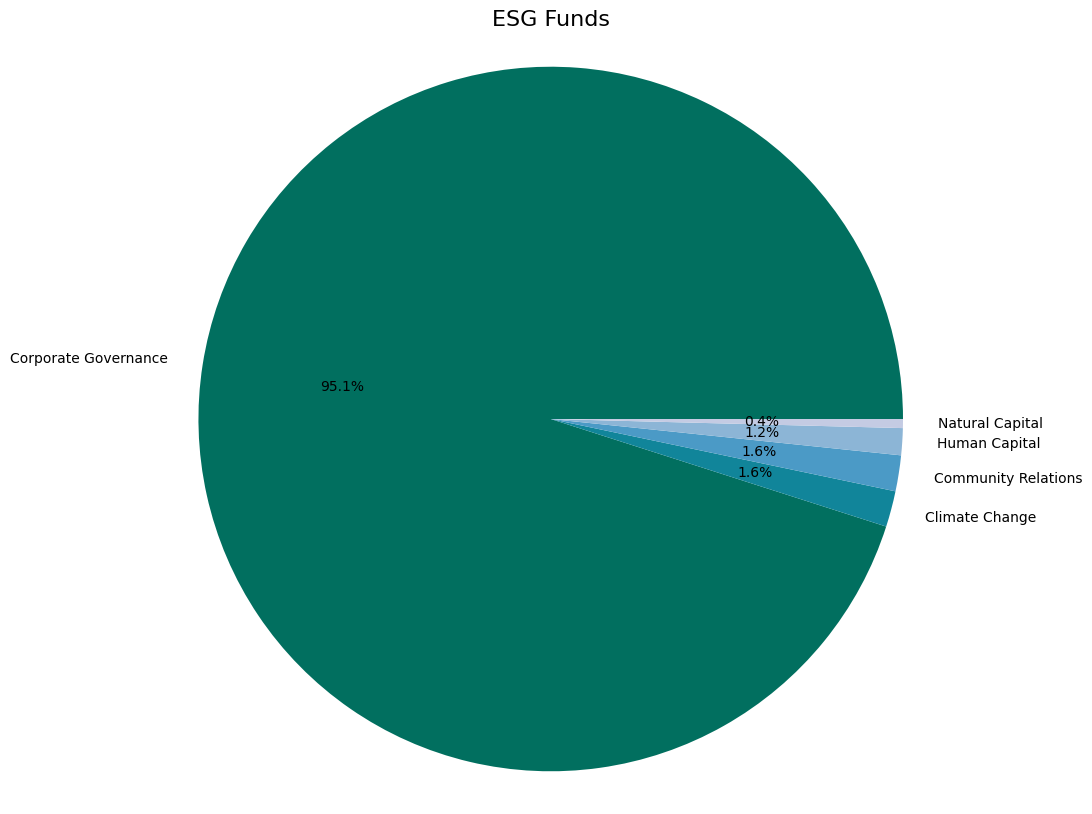

In [16]:
labels = esg_funds['esg_labels'].tolist()
sizes = esg_funds['pct_of_funds'].tolist()

fig, ax = plt.subplots(figsize=(10, 10))
colors = sns.color_palette('PuBuGn_r')[0:5]
ax.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=0, textprops={'fontsize': 10})
ax.set_title('ESG Funds', fontsize=16)
ax.axis('equal')

plt.show()

In [17]:
#check which funds are trading Coporate Governance
corporate_governance_funds = clickhouse_query('''
select distinct cik_expanded, name, year
from common_goods.last_entry
where esg_labels = 'Corporate Governance'
and year != 0
order by year, name  asc
''')

corporate_governance_funds

Elapsed time: 0 days 00:00:00 seconds


,cik_expanded,name,year
0,1365662,CLAYMORE EXCHANGE-TRADED FUND TRUST 2,2015
1,1308576,AB POOLING PORTFOLIOS,2016
2,914775,"ADVANTAGE FUNDS, INC.",2016
3,1105446,"CALVERT RESPONSIBLE INDEX SERIES, INC.",2016
4,708950,CALVERT VARIABLE SERIES INC,2016
...,...,...,...
242,732041,"FPA U.S. CORE EQUITY FUND, INC.",2021
243,1873280,KELLY STRATEGIC ETF TRUST,2021
244,860720,MORGAN STANLEY EUROPE OPPORTUNITY FUND INC.,2021
245,1848758,SHP ETF TRUST,2021


In [18]:
# check which funds are trading Climate Change

climate_change_funds = clickhouse_query('''
select distinct cik_expanded, name, year
from common_goods.last_entry
where esg_labels = 'Climate Change'
order by year, name asc
''')

climate_change_funds

Elapsed time: 0 days 00:00:00 seconds


,cik_expanded,name,year
0,877232,GREEN CENTURY FUNDS,2017
1,1095726,NATIXIS FUNDS TRUST IV,2017
2,110055,"BLACKROCK SUSTAINABLE BALANCED FUND, INC.",2022
3,1324285,BLACKROCK UNCONSTRAINED EQUITY FUND,2022


In [19]:
# check which funds are trading Human Capital
human_capital_funds = clickhouse_query('''
select distinct cik_expanded, name, year
from common_goods.last_entry
where esg_labels = 'Human Capital'
order by year, name asc
''')
human_capital_funds

Elapsed time: 0 days 00:00:00 seconds


,cik_expanded,name,year
0,1722388,IMPACT SHARES TRUST I,2018
1,1821080,HUMANKIND BENEFIT CORP,2021
2,1748425,GABELLI ETFS TRUST,2022


In [20]:
# check which funds are trading Community Relations
community_relations_funds = clickhouse_query('''
select distinct cik_expanded, name, year
from common_goods.last_entry
where esg_labels = 'Community Relations'
order by year, name asc
''')
community_relations_funds

Elapsed time: 0 days 00:00:00 seconds


,cik_expanded,name,year
0,1141819,TRUST FOR PROFESSIONAL MANAGERS,2016
1,1489215,MIRAE ASSET DISCOVERY FUNDS,2017
2,1481686,NILE CAPITAL INVESTMENT TRUST,2017
3,1811168,2ND VOTE FUNDS,2020


# <font color = 'green'> 3. Who are ESG leaders? </font>

In [42]:
from installdatabase import *
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [23]:
#first movers
clickhouse_query('''
select distinct cik_expanded, name, period_end_date
from common_goods.fund_objectives_strategy_with_labels
where esg_labels != 'Non-ESG'
and period_end_date != 0
order by period_end_date, name asc
limit 10
''')

Elapsed time: 0 days 00:00:00 seconds


,cik_expanded,name,period_end_date
0,1365662,CLAYMORE EXCHANGE-TRADED FUND TRUST 2,20151229
1,1364089,CLAYMORE EXCHANGE-TRADED FUND TRUST,20151230
2,1121624,CALVERT IMPACT FUND INC,20160201
3,1105446,"CALVERT RESPONSIBLE INDEX SERIES, INC.",20160201
4,884110,CALVERT WORLD VALUES FUND INC,20160201
5,1330833,"SMALL CAP VALUE FUND, INC.",20160213
6,1288872,"STOCK DIVIDEND FUND, INC.",20160213
7,787441,MAINSTAY FUNDS,20160229
8,1469192,MAINSTAY FUNDS TRUST,20160229
9,825062,"DEUTSCHE VALUE SERIES, INC",20160301


In [43]:
#BLACKROCK
blackrock = clickhouse_query('''
select esg_labels, count(distinct cik_expanded) as number_of_funds
from common_goods.last_entry
where year != 0
and name like '%BLACKROCK%'
group by esg_labels
''')

blackrock

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,number_of_funds
0,Non-ESG,32
1,Climate Change,2


In [44]:
#PIMCO
pimco = clickhouse_query('''
select esg_labels, count(distinct cik_expanded) as number_of_funds
from common_goods.last_entry
where year != 0
and name like '%PIMCO%'
group by esg_labels
''')

pimco

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,number_of_funds
0,Non-ESG,4


In [45]:
#PARNUSSUS
parnussus = clickhouse_query('''
select esg_labels, count(distinct cik_expanded) as number_of_funds
from common_goods.last_entry
where year != 0
and name like '%PARNASSUS%'
group by esg_labels
''')

parnussus

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,number_of_funds
0,Non-ESG,1
1,Corporate Governance,1


In [46]:
#JP MORGAN
jpm = clickhouse_query('''
select esg_labels, count(distinct cik_expanded) as number_of_funds
from common_goods.last_entry
where year != 0
and name like '%JP%'
group by esg_labels
''')

jpm

Elapsed time: 0 days 00:00:00 seconds


,esg_labels,number_of_funds
0,Non-ESG,4
1,Corporate Governance,3


# <font color = 'green'> Summary of Fundings:

1. Most of the MF investment strategies are not related to ESG.
2. The trend of ESG surfaced in 2015 and climb up since then.
3. Funds are more likely to invest within *Corporate Governance*.

All in all, it seems not a good taxonomy. So, we try to create our own taxonomy in the next section instead.

</font>